In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
# Load the dataset, selecting only the specified columns
cols = ['company_id', 'title', 'description', 'max_salary', 'med_salary', 'min_salary', 'pay_period', 
        'formatted_work_type', 'location', 'work_type', 'formatted_experience_level']
data = pd.read_csv("./raw_data/job_postings.csv", usecols=cols)

company_industries = pd.read_csv("./raw_data/company_details/company_industries.csv")
companies = pd.read_csv("./raw_data/company_details/companies.csv")


# Filter out entries lacking salary data
data = data.dropna(how="all", subset=['max_salary','med_salary', 'min_salary'])

In [59]:
data

,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,formatted_experience_level,work_type
0,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.00,NaN,MONTHLY,Full-time,"Little River, SC",Entry level,FULL_TIME
3,18213359.0,Cook,descriptionTitle\n\n Looking for a great oppor...,NaN,22.27,NaN,HOURLY,Full-time,"Aliso Viejo, CA",Entry level,FULL_TIME
4,437225.0,Principal Cloud Security Architect (Remote),"Job Summary\nAt iHerb, we are on a mission to ...",275834.0,NaN,205956.0,YEARLY,Full-time,United States,Mid-Senior level,FULL_TIME
8,18213359.0,Dishwasher,"descriptionTitle\n\n $2,000 Sign-on Bonus Guar...",NaN,19.30,NaN,HOURLY,Full-time,"Aliso Viejo, CA",Entry level,FULL_TIME
11,19181907.0,Insights Analyst - Auto Industry,Who We Are\n\nEscalent is an award-winning dat...,64000.0,NaN,58000.0,YEARLY,Full-time,United States,Entry level,FULL_TIME
...,...,...,...,...,...,...,...,...,...,...,...
33231,NaN,Mental Health Practitioners,Gail M. Yost and Associates is hiring full tim...,NaN,100000.00,NaN,YEARLY,Full-time,"Minneapolis, MN",NaN,FULL_TIME
33233,61469.0,Registered Nurse (RN) Vaccinator,United Staffing Solutions is partnering with o...,50.0,NaN,50.0,HOURLY,Part-time,"Muskegon, MI",NaN,PART_TIME
33236,3894635.0,Office Associate,Provide clerical and administrative support to...,42000.0,NaN,37000.0,YEARLY,Full-time,"Albany, GA",NaN,FULL_TIME
33244,NaN,Licensed Insurance Agent,While many industries were hurt by the last fe...,52000.0,NaN,45760.0,YEARLY,Full-time,"Chico, CA",NaN,FULL_TIME


In [60]:
# Standardizing salaries to an annual average
def standardize_salary(row):
    if pd.isnull(row['med_salary']):
        avg_salary = np.mean([row['max_salary'], row['min_salary']])
    else:
        avg_salary = row['med_salary']
    
    if row['pay_period'] == 'MONTHLY':
        return avg_salary * 12
    elif row['pay_period'] == 'WEEKLY':
        # Assuming a full-time job works 48 weeks a year
        return avg_salary * 48 
    elif row['pay_period'] == 'HOURLY':
        # Assuming a full-time job works 1920 hours a year (40 hours/week * 48 weeks)
        return avg_salary * 1920
    else:  # Assuming the salary is already yearly
        return avg_salary
    
data['standardized_annual_salary'] = data.apply(standardize_salary, axis=1)


In [61]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Clean the descriptions
def clean_description(description):
    doc = nlp(description)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(tokens)

data['cleaned_description'] = data['description'].apply(clean_description)


In [62]:
import re
from collections import Counter
import json

def clean_title(title, tokenizer):
    # Lowercase
    title = title.lower()
    # Remove special characters and numbers
    title = re.sub('[^A-Za-z ]+', ' ', title)
    # Remove multiple spaces
    title = re.sub('\\s+', ' ', title)
    title = ' '.join([w.text for w in tokenizer(title) if not w.is_stop])
    return title


def generate_vocabulary(cleaned_titles):
    tokens = []
    for title in cleaned_titles:
        tokens.extend(title.split())
    word_freq = Counter(tokens)
    vocab = sorted(word_freq, key=word_freq.get, reverse=True)[:200]
    with open('title_vocabulary.json', 'w') as f:
        json.dump(vocab, f)
    return vocab


def create_title_emb(cleaned_title, word_to_vec):
    tokens = cleaned_title.split()
    embeddings = np.array([word_to_vec[word] for word in tokens if word in word_to_vec])
    embedding = np.sum(embeddings, axis=0)
    return embedding

In [63]:
data['cleaned_title'] = data['title'].apply(lambda x: clean_title(x, nlp))

vocab = generate_vocabulary(data['cleaned_title'])
word_to_vec = {word: np.eye(len(vocab))[i] for i, word in enumerate(vocab)}

data['title_emb'] = data['cleaned_title'].apply(lambda x: create_title_emb(x, word_to_vec))

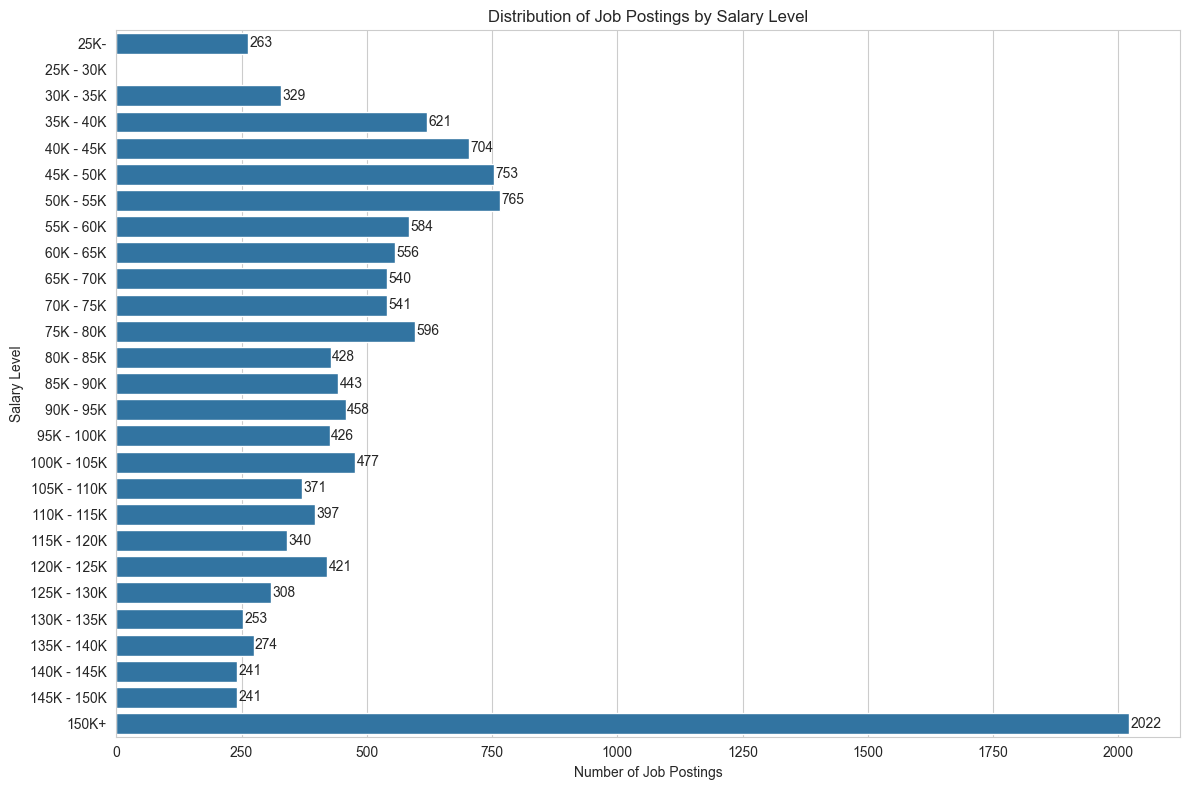

In [64]:
import seaborn as sns

# Define the bins for the salary ranges
bins = [0, 25000] + list(range(25001, 150001, 5000)) + [float('inf')]

# Define the labels for each bin
labels = ['25K-'] + [f"{i}K - {i + 5}K" for i in range(25, 150, 5)] + ['150K+']

data['salary_level'] = pd.cut(data['standardized_annual_salary'], bins=bins, labels=labels, right=False)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plot to visualize the count of job postings in each salary bin
plt.figure(figsize=(12, 8))
ax = sns.countplot(data=data, y='salary_level', order=data['salary_level'].cat.categories)
plt.title('Distribution of Job Postings by Salary Level')
plt.xlabel('Number of Job Postings')
plt.ylabel('Salary Level')
plt.tight_layout()

# Add labels to each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 3, p.get_y() + p.get_height() / 2,
             f'{int(width)}',
             va='center')

# Show the plot
plt.show()

In [65]:
# Merge company data
data = data.merge(companies, on='company_id', how='left')
data = data.merge(company_industries, on='company_id', how='left')

final_processed_data = data[[
    'company_id', 'name', 'industry', 'cleaned_title', 'cleaned_description', 'work_type',
    'location', 'formatted_experience_level', 'standardized_annual_salary', 'salary_level', 'title_emb'
]]

final_processed_data.to_csv("../data/processed_job_postings.csv", index=False)

In [66]:
final_processed_data

,company_id,name,industry,cleaned_title,cleaned_description,work_type,location,formatted_experience_level,standardized_annual_salary,salary_level,title_emb
0,553718.0,HearingLife,Retail,hearing care provider,overview HearingLife national hearing care com...,FULL_TIME,"Little River, SC",Entry level,63000.0,65K - 70K,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,18213359.0,Episcopal Communities & Services,Non-profit Organization Management,cook,descriptiontitle look great opportunity develo...,FULL_TIME,"Aliso Viejo, CA",Entry level,42758.4,45K - 50K,0.0
2,18213359.0,Episcopal Communities & Services,Non-profit Organizations,cook,descriptiontitle look great opportunity develo...,FULL_TIME,"Aliso Viejo, CA",Entry level,42758.4,45K - 50K,0.0
3,437225.0,"iHerb, LLC",Retail,principal cloud security architect remote,Job Summary iHerb mission health wellness acce...,FULL_TIME,United States,Mid-Senior level,240895.0,150K+,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,18213359.0,Episcopal Communities & Services,Non-profit Organization Management,dishwasher,descriptiontitle sign Bonus guarantee look foo...,FULL_TIME,"Aliso Viejo, CA",Entry level,37056.0,40K - 45K,0.0
...,...,...,...,...,...,...,...,...,...,...,...
18452,NaN,NaN,NaN,mental health practitioners,Gail Yost Associates hire time license mental ...,FULL_TIME,"Minneapolis, MN",NaN,100000.0,100K - 105K,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18453,61469.0,United Staffing Solutions (USS),Staffing & Recruiting,registered nurse rn vaccinator,United Staffing Solutions partner big covid va...,PART_TIME,"Muskegon, MI",NaN,96000.0,100K - 105K,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
18454,3894635.0,Sunnyland Farms,Retail,office associate,provide clerical administrative support manage...,FULL_TIME,"Albany, GA",NaN,39500.0,40K - 45K,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
18455,NaN,NaN,NaN,licensed insurance agent,industry hurt year people need insurance posit...,FULL_TIME,"Chico, CA",NaN,48880.0,50K - 55K,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


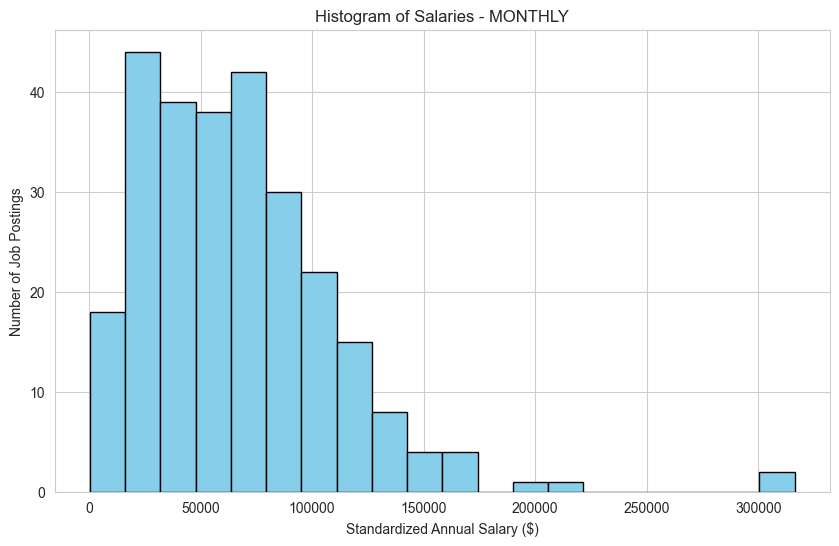

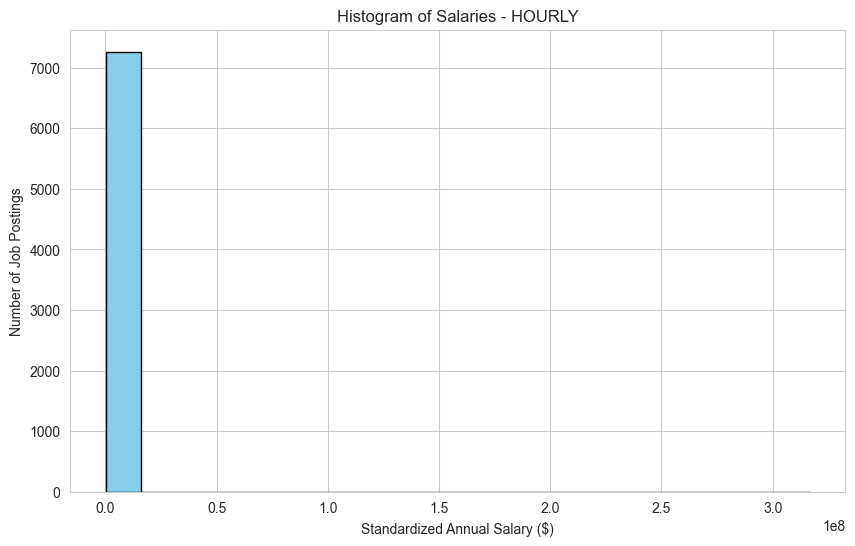

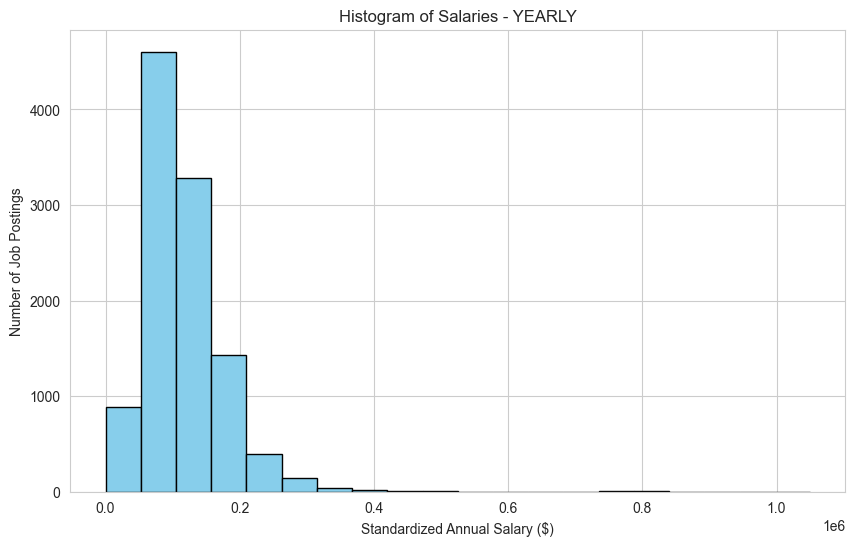

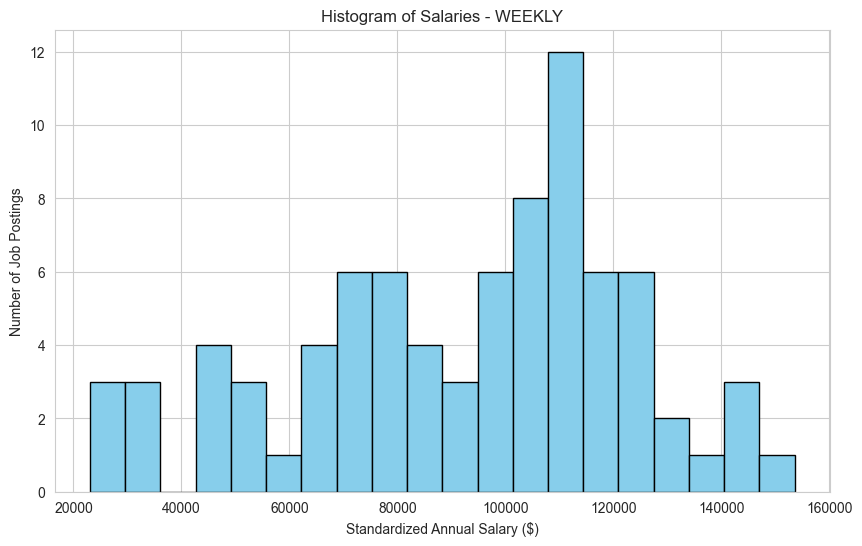

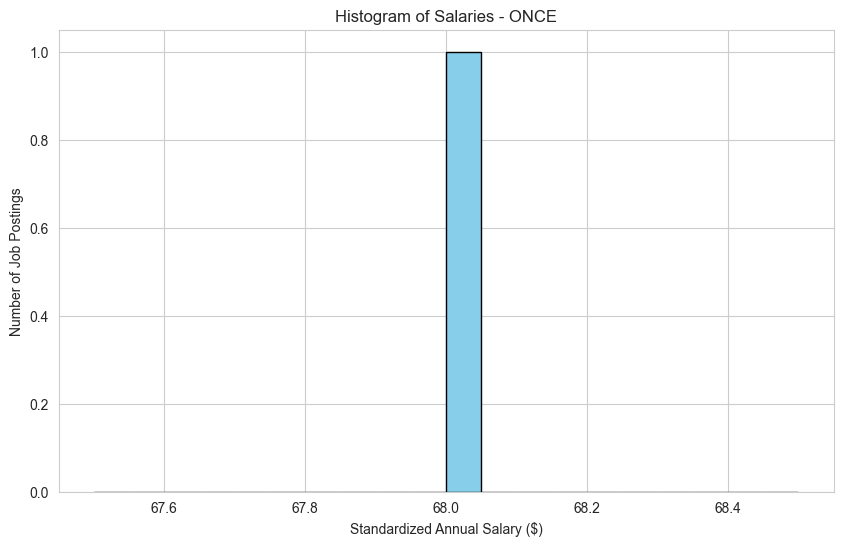

In [67]:
def plot_salary_by_pay_period(data, pay_period):
    # Filter data for the specific pay period
    subset = data[data['pay_period'] == pay_period]
    
    # Create a histogram for the filtered data
    plt.figure(figsize=(10, 6))
    plt.hist(subset['standardized_annual_salary'], bins=20, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of Salaries - {pay_period}')
    plt.xlabel('Standardized Annual Salary ($)')
    plt.ylabel('Number of Job Postings')
    plt.grid(True)
    plt.show()

pay_periods = data['pay_period'].unique()

# Generate a histogram for each pay period
for period in pay_periods:
    plot_salary_by_pay_period(data, period)